# cMamba; F = 10; T = 1000


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96
from cmamba import cMamba, train_model_ista, MambaConfig

In [ ]:
# For GPU acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Simulate data
X_np, GC = simulate_lorenz_96(p=20, F=10, T=1000)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

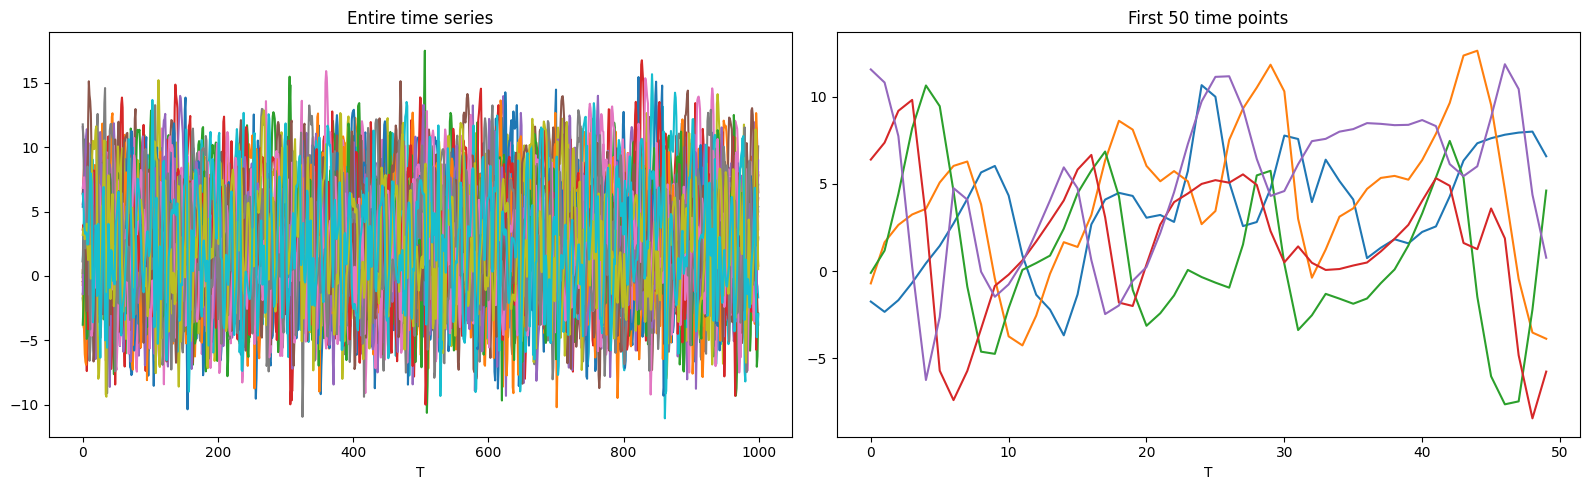

In [7]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50, :5])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

----------Iter = 50----------
Loss = 464.835999
Variable usage = 100.00%
----------Iter = 100----------
Loss = 418.433075
Variable usage = 100.00%
----------Iter = 150----------
Loss = 372.370697
Variable usage = 100.00%
----------Iter = 200----------
Loss = 326.735443
Variable usage = 100.00%
----------Iter = 250----------
Loss = 281.547363
Variable usage = 100.00%
----------Iter = 300----------
Loss = 236.990234
Variable usage = 100.00%
----------Iter = 350----------
Loss = 193.079819
Variable usage = 100.00%
----------Iter = 400----------
Loss = 150.019272
Variable usage = 100.00%
----------Iter = 450----------
Loss = 107.992241
Variable usage = 100.00%
----------Iter = 500----------
Loss = 67.935951
Variable usage = 99.25%
----------Iter = 550----------
Loss = 36.925465
Variable usage = 77.25%
----------Iter = 600----------
Loss = 24.567152
Variable usage = 38.25%
----------Iter = 650----------
Loss = 21.691076
Variable usage = 18.25%
----------Iter = 700----------
Loss = 20.702444

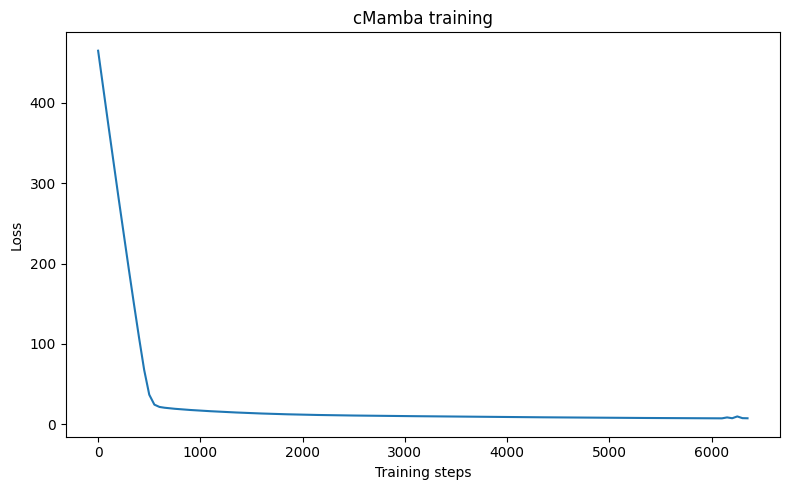

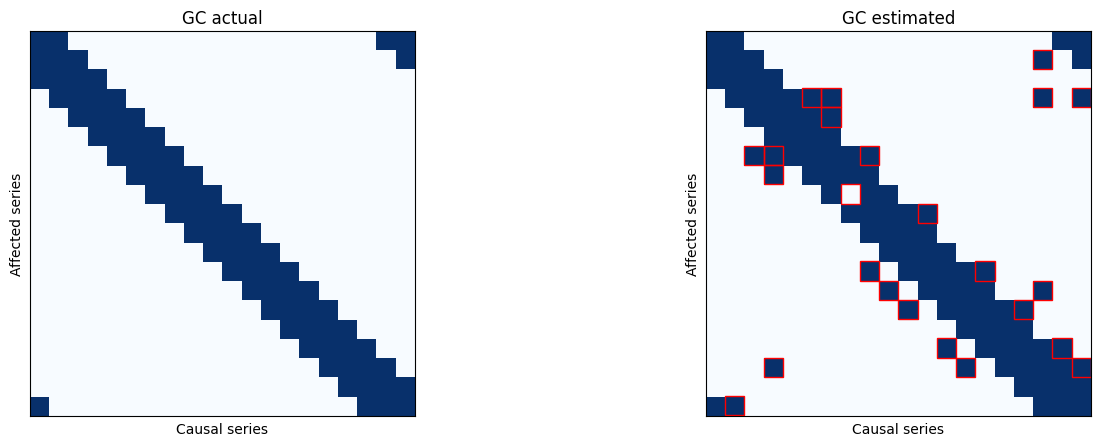

In [6]:
  #cMamba config
  cmamba_config = MambaConfig(d_model = 20, dt_rank = 4, d_state = 25, bias = True)
  #Set up model
  cmamba = cMamba(cmamba_config).to(device=device)

  # Train with ISTA
  train_loss_list=train_model_ista(cmamba, X, context=10, lr=1e-4, max_iter=30000, lam=21, lam_ridge=1e-3,
                   check_every=50)

  # Loss function plot
  plt.figure(figsize=(8, 5))
  train_loss_np = [loss.cpu().detach().numpy() for loss in train_loss_list]
  plt.plot(50 * np.arange(len(train_loss_np)), train_loss_np)
  plt.title('cMamba training')
  plt.ylabel('Loss')
  plt.xlabel('Training steps')
  plt.tight_layout()
  plt.show()

  # Verify learned Granger causality
  GC_est = cmamba.GC().cpu().data.numpy()

  # Make figures for Granger causality matrices
  fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
  axarr[0].imshow(GC, cmap='Blues')
  axarr[0].set_title('GC actual')
  axarr[0].set_ylabel('Affected series')
  axarr[0].set_xlabel('Causal series')
  axarr[0].set_xticks([])
  axarr[0].set_yticks([])

  axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
  axarr[1].set_title('GC estimated')
  axarr[1].set_ylabel('Affected series')
  axarr[1].set_xlabel('Causal series')
  axarr[1].set_xticks([])
  axarr[1].set_yticks([])

  # Mark disagreements
  for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

  plt.show()